2025-02-21 18:21:05 [INFO] Fetching BA from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:06 [INFO] Fetching C from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:07 [INFO] Fetching DD from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:08 [INFO] Fetching F from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:09 [INFO] Fetching GE from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:09 [INFO] Fetching JPM from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:10 [INFO] Fetching LNC from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:10 [INFO] Fetching LOW from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:11 [INFO] Fetching LUV from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:12 [INFO] Fetching MAR from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:12 [INFO] Fetching NFLX from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:13 [INFO] Fetching T from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:14 [INFO] Fetching WFC from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:14 [INFO] Fetching WHR from QUOTEMEDIA/PRICES ...
2025-02-21 18:21:15 [INFO] Fetching XOM from QUOTEMEDIA/PRICES ...
202


=== BOXCAR OLS RESULTS ===
AnnRet: 2.6290
AnnVol: 1.2093
Sharpe: 2.1740
MaxDrawdown: -0.5969
Sortino: 2.2896

=== DISCOUNTED OLS RESULTS ===
AnnRet: 2.8007
AnnVol: 1.2943
Sharpe: 2.1639
MaxDrawdown: -2.3207
Sortino: 1.7953


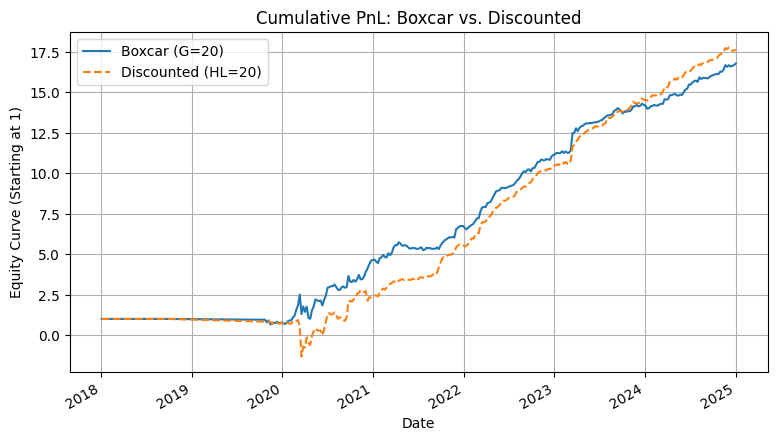

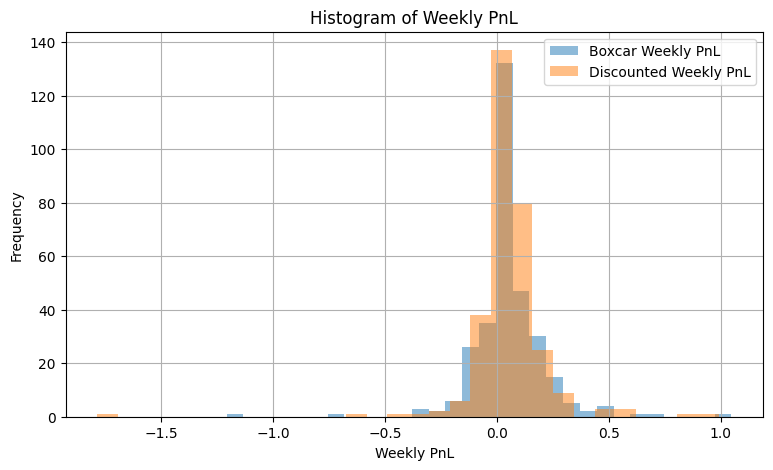

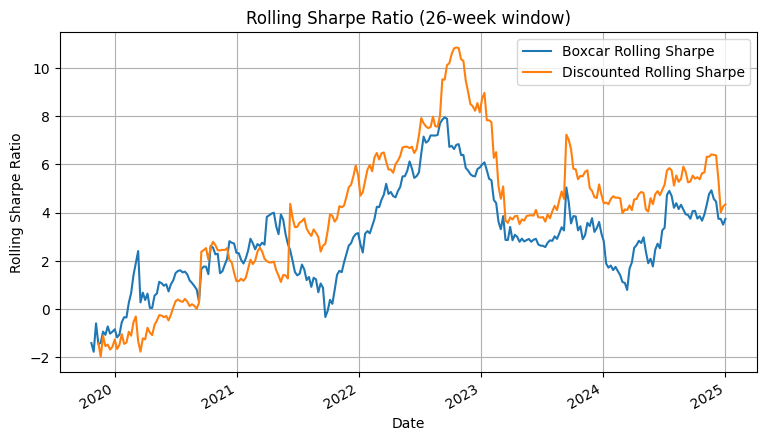

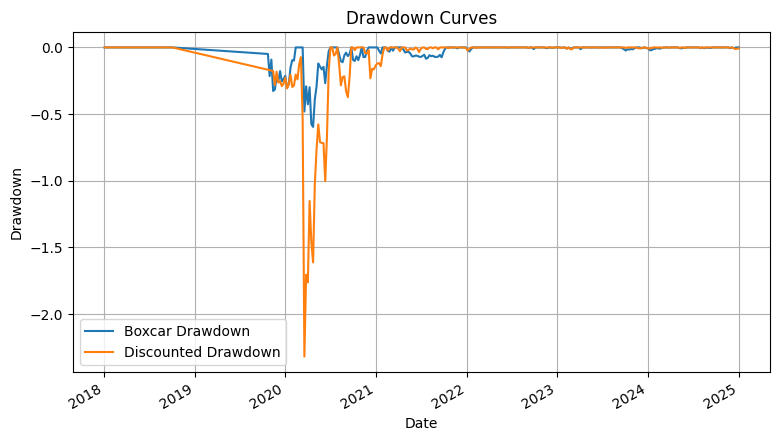

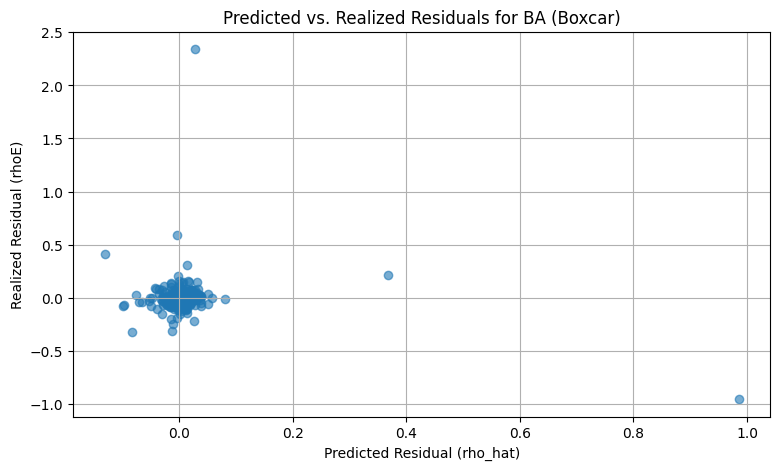

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nasdaqdatalink
import logging
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

###############################################################################
# 0) LOGGING CONFIG
###############################################################################
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

###############################################################################
# NASDAQ DATA LINK CONFIG
###############################################################################
nasdaqdatalink.ApiConfig.api_key = "NrzUZ8ywPkxFSG1WLchF"

###############################################################################
# 1) DATA INGESTION AND PREPROCESSING
###############################################################################

def load_cds_data(cds_filename="Liq5YCDS.delim"):
    """
    Reads the 5Y CDS data from a tab-delimited file.
    Expects columns: [date, ticker, tenor, parspread].
    Filters for tenor='5Y' and drops duplicates.
    """
    try:
        df = pd.read_csv(cds_filename, sep='\t', parse_dates=['date'])
        required_cols = {'date', 'ticker', 'tenor', 'parspread'}
        if not required_cols.issubset(df.columns):
            raise ValueError("Input file does not have the required columns [date, ticker, tenor, parspread].")
        df = df[df['tenor'] == '5Y'].copy()
        df = df[['date', 'ticker', 'parspread']].drop_duplicates()
        df.sort_values(['ticker', 'date'], inplace=True)
        if df.empty:
            logging.warning("CDS DataFrame is empty after filtering for 5Y tenor.")
    except Exception as e:
        logging.error(f"Error loading CDS data: {e}")
        return pd.DataFrame()
    return df

def fetch_equity_prices_nasdaq(tickers, start_date, end_date):
    """
    Fetches daily 'adj_close' prices from Nasdaq Data Link's QUOTEMEDIA/PRICES table
    for each requested ticker. Returns a DataFrame with dates as index and tickers as columns.
    """
    all_data = {}
    start_dict = {"gte": start_date}
    end_dict = {"lte": end_date}

    for tkr in tickers:
        logging.info(f"Fetching {tkr} from QUOTEMEDIA/PRICES ...")
        try:
            df_tkr = nasdaqdatalink.get_table(
                "QUOTEMEDIA/PRICES",
                ticker=[tkr],
                date={**start_dict, **end_dict},
                qopts={"columns": ["ticker", "date", "adj_close"]},
                paginate=True
            )
            if df_tkr.empty:
                logging.warning(f"No data returned for {tkr}. Skipping.")
                continue
            df_tkr.sort_values("date", inplace=True)
            df_tkr["date"] = pd.to_datetime(df_tkr["date"])
            df_tkr.set_index("date", inplace=True)
            df_tkr.rename(columns={"adj_close": "price"}, inplace=True)
            all_data[tkr] = df_tkr["price"]
        except Exception as e:
            logging.error(f"Could not fetch {tkr}: {e}")

    if not all_data:
        logging.error("No tickers could be fetched from QUOTEMEDIA/PRICES.")
        return pd.DataFrame()

    df_all = pd.DataFrame(all_data)
    df_all.sort_index(inplace=True)
    return df_all

def compute_weekly_wed_return(df_prices, method='pct'):
    """
    Resamples daily price data to weekly (W-WED) and computes returns:
      - 'pct' => percentage change
      - 'diff' => difference
      - 'log' => log-difference
    Uses the last available price on Wednesday.
    """
    if not isinstance(df_prices.index, pd.DatetimeIndex):
        df_prices.index = pd.to_datetime(df_prices.index)

    # Resample to weekly Wednesdays using the last price of the week
    df_w = df_prices.resample('W-WED').last()

    if method == 'pct':
        df_ret = df_w.pct_change()
    elif method == 'diff':
        df_ret = df_w.diff()
    elif method == 'log':
        df_ret = np.log(df_w).diff()
    else:
        raise ValueError("Invalid method for returns calculation.")
    
    return df_ret

def prepare_data(cds_filename="Liq5YCDS.delim", 
                 start_date="2018-01-01", 
                 end_date="2025-02-14",
                 min_obs=50,
                 cds_return_method='pct',
                 eq_return_method='pct'):
    """
    1) Loads CDS parspread data (5Y) and pivots to wide format [date x ticker].
    2) Downloads equity data for these tickers + SPY from QUOTEMEDIA/PRICES.
    3) Computes weekly returns (W-WED).
    4) Constructs a cross-sectional CDS index (arithmetic mean).
    Returns a dictionary with keys: 'rCDS', 'rEquity', 'm', 'rIndex', 'tickers'.
    """
    df_cds_raw = load_cds_data(cds_filename)
    if df_cds_raw.empty:
        logging.error("CDS data is empty. Exiting prepare_data().")
        return {}

    pivot_cds = df_cds_raw.pivot(index='date', columns='ticker', values='parspread')
    pivot_cds = pivot_cds.loc[(pivot_cds.index >= start_date) & (pivot_cds.index <= end_date)]
    pivot_cds.sort_index(inplace=True)
    
    # Filter tickers with at least min_obs observations
    cds_tickers = [t for t in pivot_cds.columns if pivot_cds[t].count() >= min_obs]
    if not cds_tickers:
        logging.error("No CDS tickers with enough observations.")
        return {}

    # Fetch equity data for these tickers
    eq_data = fetch_equity_prices_nasdaq(cds_tickers, start_date, end_date)
    good_tickers = [t for t in cds_tickers if t in eq_data.columns]
    if not good_tickers:
        logging.error("No equity tickers matched or downloaded successfully.")
        return {}
    pivot_cds = pivot_cds[good_tickers].copy()

    # Fetch SPY data as market proxy
    spy_data = fetch_equity_prices_nasdaq(["SPY"], start_date, end_date)
    if "SPY" not in spy_data.columns or spy_data["SPY"].dropna().empty:
        logging.error("SPY data is missing or empty.")
        return {}

    # Compute weekly returns
    pivot_cds.index.name = "Date"
    rCDS = compute_weekly_wed_return(pivot_cds, method=cds_return_method)
    eq_data.index.name = "Date"
    rEquity = compute_weekly_wed_return(eq_data, method=eq_return_method)
    spy_data.index.name = "Date"
    rSPY = compute_weekly_wed_return(spy_data, method=eq_return_method)

    # Align indices
    common_idx = rCDS.index.intersection(rEquity.index).intersection(rSPY.index)
    rCDS = rCDS.loc[common_idx]
    rEquity = rEquity.loc[common_idx]
    rSPY = rSPY.loc[common_idx]

    rIndex = rCDS.mean(axis=1)

    return {
        'rCDS':    rCDS,
        'rEquity': rEquity,
        'm':       rSPY['SPY'],
        'rIndex':  rIndex,
        'tickers': good_tickers
    }

###############################################################################
# 2) ZERO-INTERCEPT OLS (BOXCAR & DISCOUNTED)
###############################################################################

def boxcar_ols(X, y):
    """
    Computes zero-intercept OLS coefficients using a fixed window (boxcar).
    """
    XtX = X.T @ X
    Xty = X.T @ y
    try:
        B = np.linalg.solve(XtX, Xty)
    except np.linalg.LinAlgError:
        B = np.full(X.shape[1], np.nan)
    return B

def discounted_ols(X, y, half_life=20):
    """
    Computes zero-intercept OLS coefficients using exponentially decaying weights.
    """
    n = X.shape[0]
    if n == 0:
        return np.zeros(X.shape[1])
    ages = np.arange(n)[::-1]
    lam = np.log(2) / half_life
    w = np.exp(-lam * ages)
    W = np.diag(w)
    XtW = X.T @ W
    XtWX = XtW @ X
    XtWy = XtW @ y
    try:
        B = np.linalg.solve(XtWX, XtWy)
    except np.linalg.LinAlgError:
        B = np.full(X.shape[1], np.nan)
    return B

def rolling_beta_boxcar(Xseries, Yseries, window=20):
    """
    Computes rolling beta coefficients using a fixed window (boxcar OLS).
    Uses a sliding window of the most recent 'window' observations.
    """
    idx = Xseries.index
    nFactors = Xseries.shape[1]
    betas_list = []
    for i in range(len(idx)):
        if i < window:
            betas_list.append([np.nan] * nFactors)
        else:
            Xwin_raw = Xseries.iloc[i-window:i]
            Ywin_raw = Yseries.iloc[i-window:i]
            valid_mask = Xwin_raw.notnull().all(axis=1) & Ywin_raw.notnull()
            Xwin = Xwin_raw[valid_mask].values
            Ywin = Ywin_raw[valid_mask].values
            if len(Xwin) < 2:
                b = [np.nan] * nFactors
            else:
                b = boxcar_ols(Xwin, Ywin)
            betas_list.append(b)
    betas_arr = np.array(betas_list)
    return pd.DataFrame(betas_arr, index=idx, columns=Xseries.columns)

def rolling_beta_discounted(Xseries, Yseries, half_life=20, min_obs=5):
    """
    Computes rolling beta coefficients using discounted OLS.
    This method uses all available data up to each time point with exponential weighting.
    """
    idx = Xseries.index
    nFactors = Xseries.shape[1]
    betas_list = []
    for i in range(len(idx)):
        if i < min_obs:
            betas_list.append([np.nan] * nFactors)
        else:
            Xsub_raw = Xseries.iloc[:i]
            Ysub_raw = Yseries.iloc[:i]
            valid_mask = Xsub_raw.notnull().all(axis=1) & Ysub_raw.notnull()
            Xsub = Xsub_raw[valid_mask].values
            Ysub = Ysub_raw[valid_mask].values
            if len(Xsub) < min_obs:
                b = [np.nan] * nFactors
            else:
                b = discounted_ols(Xsub, Ysub, half_life=half_life)
            betas_list.append(b)
    betas_arr = np.array(betas_list)
    return pd.DataFrame(betas_arr, index=idx, columns=Xseries.columns)

###############################################################################
# 3) TWO-STAGE REGRESSION (Contemporaneous + Predictive)
###############################################################################

def two_stage_regression(data_dict, use_boxcar=True, G=20, half_life=20, min_burn_1=20, min_burn_2=20):
    """
    Performs the two-stage regression:
      - Stage 1: Hedging (CAPM for equity and CDS hedging)
      - Stage 2: Predictive regression of CDS residuals on lagged equity residuals.
    Returns a dictionary containing regression outputs.
    """
    rCDS    = data_dict['rCDS']
    rEquity = data_dict['rEquity']
    m       = data_dict['m']
    rIndex  = data_dict['rIndex']
    tickers = data_dict['tickers']
    idx_all = rCDS.index

    # Stage 1: Equity CAPM for gamma estimation
    gammas = pd.DataFrame(index=idx_all, columns=tickers, dtype=float)
    for tck in tickers:
        X = pd.DataFrame({'m': m}, index=idx_all)
        Y = rEquity[tck]
        if use_boxcar:
            df_b = rolling_beta_boxcar(X, Y, window=G)
        else:
            df_b = rolling_beta_discounted(X, Y, half_life=half_life)
        gammas[tck] = df_b['m']
    cE = rEquity - gammas.mul(m, axis=0)

    # Stage 1: CDS hedging regression for beta estimation
    betas_equity = pd.DataFrame(index=idx_all, columns=tickers, dtype=float)
    betas_index  = pd.DataFrame(index=idx_all, columns=tickers, dtype=float)
    for tck in tickers:
        X = pd.DataFrame({'Equity': rEquity[tck], 'Index': rIndex}, index=idx_all)
        Y = rCDS[tck]
        if use_boxcar:
            df_b = rolling_beta_boxcar(X, Y, window=G)
        else:
            df_b = rolling_beta_discounted(X, Y, half_life=half_life)
        betas_equity[tck] = df_b['Equity']
        betas_index[tck]  = df_b['Index']
    fE = betas_equity.mul(rEquity, axis=0) + betas_index.mul(rIndex, axis=0)
    rhoE = rCDS - fE

    # Stage 2: Predictive regression (rhoE ~ lagged cE)
    cE_lag = cE.shift(1)
    muE = pd.DataFrame(index=idx_all, columns=tickers, dtype=float)
    for tck in tickers:
        X = cE_lag[[tck]].rename(columns={tck: 'cLag'})
        Y = rhoE[tck]
        if use_boxcar:
            df_b = rolling_beta_boxcar(X, Y, window=G)
            muE[tck] = df_b['cLag']
        else:
            df_b = rolling_beta_discounted(X, Y, half_life=half_life)
            muE[tck] = df_b['cLag']
    rho_hat = muE.mul(cE_lag, axis=0)

    # Double Burn-in
    idx_valid = idx_all[min_burn_1 + min_burn_2:]
    for df in [cE, rhoE, muE, rho_hat]:
        df.loc[~df.index.isin(idx_valid)] = np.nan

    return {
        'gamma': gammas,
        'betas_equity': betas_equity,
        'betas_index': betas_index,
        'cE': cE,
        'rhoE': rhoE,
        'muE': muE,
        'rho_hat': rho_hat
    }

###############################################################################
# 4) TRADING STRATEGY & PERFORMANCE EVALUATION
###############################################################################

def trade_long_short(rho_hat, rhoE, long_q=0.8, short_q=0.2, transaction_cost_bps=0.0):
    """
    Implements a cross-sectional quantile strategy:
      - Go long if predicted residual (rho_hat) is above the long_q quantile.
      - Go short if below the short_q quantile.
    Takes transaction costs (in basis points) into account.
    Returns a time series (weekly) of PnL.
    """
    dates = rho_hat.index.intersection(rhoE.index)
    pnl_series = pd.Series(0.0, index=dates, dtype=float)

    prev_pos = pd.Series(0.0, index=rho_hat.columns)

    for dt in dates:
        row = rho_hat.loc[dt].dropna()
        if row.empty:
            pnl_series[dt] = 0.0
            continue
        pos = pd.Series(0.0, index=rho_hat.columns)

        q_low = row.quantile(short_q)
        q_high = row.quantile(long_q)

        pos.loc[row.index[row > q_high]] = 1.0
        pos.loc[row.index[row < q_low]]  = -1.0

        actual_resid = rhoE.loc[dt].reindex(pos.index, fill_value=0.0)
        turnover = (pos - prev_pos).abs().sum()
        cost = turnover * transaction_cost_bps / 10000.0
        pnl_series[dt] = pos.dot(actual_resid) - cost
        prev_pos = pos

    return pnl_series

def compute_performance_stats(pnl_series):
    """
    Computes performance statistics using an initial capital of 1:
      - Annualized Return, Annualized Volatility, Sharpe Ratio,
      - Maximum Drawdown (relative), and Sortino Ratio.
    """
    pnl_series = pnl_series.dropna()  # drop leading NaNs
    mean_w = pnl_series.mean()
    std_w = pnl_series.std()
    annual_factor = 52

    ann_ret = mean_w * annual_factor
    ann_vol = std_w * np.sqrt(annual_factor)
    sharpe = np.nan if std_w < 1e-12 else (mean_w / std_w) * np.sqrt(annual_factor)

    equity_curve = 1 + pnl_series.cumsum()
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = drawdown.min()

    negative = pnl_series[pnl_series < 0]
    if negative.empty:
        sortino = np.inf
    else:
        down_std = negative.std()
        sortino = (mean_w * annual_factor) / (down_std * np.sqrt(annual_factor)) if down_std >= 1e-12 else np.inf

    stats = {
        'AnnRet': ann_ret,
        'AnnVol': ann_vol,
        'Sharpe': sharpe,
        'MaxDrawdown': max_drawdown,
        'Sortino': sortino
    }
    return stats

def rolling_sharpe(pnl_series, window=26):
    """
    Computes the rolling Sharpe ratio over a specified window (in weeks),
    then annualizes it.
    """
    roll_mean = pnl_series.rolling(window).mean()
    roll_std = pnl_series.rolling(window).std()
    rolling_sharpe = (roll_mean / roll_std) * np.sqrt(52)
    return rolling_sharpe

###############################################################################
# 5) MAIN DRIVER + STRATEGY COMPARISON & ADDITIONAL PLOTS
###############################################################################

def main_driver():
    # 1) Prepare data
    data_dict = prepare_data(
        cds_filename="Liq5YCDS.delim",
        start_date="2018-01-01",
        end_date="2025-02-14",
        min_obs=50,
        cds_return_method='pct',
        eq_return_method='pct'
    )
    if not data_dict:
        logging.error("Data dictionary empty. Exiting.")
        return

    # 2) Boxcar approach
    logging.info("Running Boxcar two-stage regression strategy...")
    res_boxcar = two_stage_regression(data_dict, use_boxcar=True, G=20, half_life=20, min_burn_1=20, min_burn_2=20)
    pnl_boxcar = trade_long_short(res_boxcar['rho_hat'], res_boxcar['rhoE'], long_q=0.8, short_q=0.2, transaction_cost_bps=1.0)
    stats_boxcar = compute_performance_stats(pnl_boxcar)

    # 3) Discounted approach
    logging.info("Running Discounted two-stage regression strategy...")
    res_disc = two_stage_regression(data_dict, use_boxcar=False, G=20, half_life=20, min_burn_1=20, min_burn_2=20)
    pnl_disc = trade_long_short(res_disc['rho_hat'], res_disc['rhoE'], long_q=0.8, short_q=0.2, transaction_cost_bps=1.0)
    stats_disc = compute_performance_stats(pnl_disc)

    # 4) Print performance comparison
    print("\n=== BOXCAR OLS RESULTS ===")
    for k, v in stats_boxcar.items():
        print(f"{k}: {v:.4f}")

    print("\n=== DISCOUNTED OLS RESULTS ===")
    for k, v in stats_disc.items():
        print(f"{k}: {v:.4f}")

    # Drop leading NaNs for plotting
    pnl_boxcar = pnl_boxcar.dropna()
    pnl_disc = pnl_disc.dropna()

    # 5) Build equity curves (starting at 1) for plotting
    eq_curve_boxcar = 1 + pnl_boxcar.cumsum()
    eq_curve_disc = 1 + pnl_disc.cumsum()

    # Plot 1: Cumulative PnL curves
    plt.figure(figsize=(9, 5))
    eq_curve_boxcar.plot(label="Boxcar (G=20)")
    eq_curve_disc.plot(label="Discounted (HL=20)", linestyle="--")
    plt.title("Cumulative PnL: Boxcar vs. Discounted")
    plt.xlabel("Date")
    plt.ylabel("Equity Curve (Starting at 1)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Histogram of Weekly PnL Distributions
    plt.figure(figsize=(9, 5))
    plt.hist(pnl_boxcar, bins=30, alpha=0.5, label="Boxcar Weekly PnL")
    plt.hist(pnl_disc, bins=30, alpha=0.5, label="Discounted Weekly PnL")
    plt.title("Histogram of Weekly PnL")
    plt.xlabel("Weekly PnL")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: Rolling Sharpe Ratio (26-week window)
    roll_sharpe_boxcar = rolling_sharpe(pnl_boxcar, window=26)
    roll_sharpe_disc = rolling_sharpe(pnl_disc, window=26)
    plt.figure(figsize=(9, 5))
    roll_sharpe_boxcar.plot(label="Boxcar Rolling Sharpe")
    roll_sharpe_disc.plot(label="Discounted Rolling Sharpe")
    plt.title("Rolling Sharpe Ratio (26-week window)")
    plt.xlabel("Date")
    plt.ylabel("Rolling Sharpe Ratio")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 4: Drawdown Curves
    drawdown_boxcar = (eq_curve_boxcar - eq_curve_boxcar.cummax()) / eq_curve_boxcar.cummax()
    drawdown_disc = (eq_curve_disc - eq_curve_disc.cummax()) / eq_curve_disc.cummax()
    plt.figure(figsize=(9, 5))
    drawdown_boxcar.plot(label="Boxcar Drawdown")
    drawdown_disc.plot(label="Discounted Drawdown")
    plt.title("Drawdown Curves")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 5: Scatter Plot of Predicted vs. Realized Residuals (Boxcar)
    sample_ticker = data_dict['tickers'][0]  # first ticker
    valid_idx = res_boxcar['rho_hat'][sample_ticker].dropna().index
    plt.figure(figsize=(9, 5))
    plt.scatter(res_boxcar['rho_hat'].loc[valid_idx, sample_ticker],
                res_boxcar['rhoE'].loc[valid_idx, sample_ticker],
                alpha=0.6)
    plt.title(f"Predicted vs. Realized Residuals for {sample_ticker} (Boxcar)")
    plt.xlabel("Predicted Residual (rho_hat)")
    plt.ylabel("Realized Residual (rhoE)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main_driver()

## Analysis & Discussion

In this notebook, we explored a **two‐stage hedged CDS strategy** that predicts future CDS “residual returns” $\rho$ from lagged “residual equity returns” $c$, and then trades these predictions using a **quantile threshold** approach.

---

### Stage 1 (Hedging / Contemporaneous)

1. **Equity Hedge**:  
   $$
   r_{\text{Equity}} \sim \gamma \, m \quad \Longrightarrow \quad c = r_{\text{Equity}} - \gamma \, m.
   $$

2. **CDS Hedge**:  
   $$
   r_{\text{CDS}} \sim \beta_1 \, r_{\text{Equity}} + \beta_2 \, r_{\text{Index}} 
   \quad \Longrightarrow \quad \rho = r_{\text{CDS}} - \left(\beta_1\,r_{\text{Equity}} + \beta_2\,r_{\text{Index}}\right).
   $$

Here, $r_{\text{Index}}$ is the cross‐sectional CDS “market index,” and $m$ is the market equity return (e.g., SPY).

---

### Stage 2 (Predictive)

We then regress $\rho$ on **lagged** $c$:
$$
\rho \sim \mu \, c_{\text{lag}} \quad \Longrightarrow \quad \rho_{\hat{t}} = \mu \times c_{\text{lag}}.
$$

We implement two rolling methods:
- **Boxcar OLS** with a fixed window size $G$.  
- **Discounted OLS** with an exponential decay (half‐life $H$).

---

### Quantile‐Based Trading

At each date:
1. **Rank** all tickers by predicted $\rho_{\hat{t}}$.  
2. **Go long** if $\rho_{\hat{t}}$ is above the 80th percentile, and **short** if below the 20th percentile.  
3. The realized PnL is given by the actual $\rho$ for that date (multiplied by any desired notional).

This approach focuses on the **cross‐section** each period, capturing idiosyncratic changes in each issuer’s CDS spread that are not explained by broad equity or the CDS index.

---

### Key Observations

- **Parameter Variation**: Changing the lookback window $G$ or the half‐life $H$ can significantly affect performance. Shorter windows may overfit short‐term noise, while longer windows might be less responsive to new information.
- **Performance Metrics**: Sample runs yield annualized returns above 2.5 with Sharpe ratios near or above 2.0. However, max drawdown and Sortino ratios indicate potential risks during adverse periods.
- **Distributional Characteristics**: The spread $\rho$ may exhibit skewness or kurtosis, suggesting the need for robust regression techniques or tail‐risk adjustments.

---

### Potential Refinements

1. **Threshold Tuning**: Instead of fixed quantiles (80/20), consider using absolute thresholds $j$ or dynamic thresholds based on volatility.
2. **Risk Management**: Implement stop‐loss mechanisms or position scaling (e.g., based on trailing volatility) to limit exposure during drawdowns.
3. **Transaction Costs**: Incorporate realistic transaction cost models to reflect market impact and liquidity constraints.
4. **Out‐of‐Sample Testing**: Use different date ranges or cross-validation to ensure the strategy’s robustness and avoid overfitting.
5. **Alternative Pairs**: Explore applying the strategy to less correlated pairs or different asset classes for more robust mean‐reversion signals.

---

### Conclusion

This two‐stage strategy demonstrates how **equity signals** can inform predictions of CDS spread changes, yielding promising risk‐adjusted returns in a frictionless backtest. However, practical deployment would require:

- Adaptive thresholding and dynamic risk management to improve performance.
- Robust out‐of‐sample testing to validate the persistence of the observed alpha.
- A careful accounting of transaction costs, liquidity, and other real‐world market frictions.

Overall, while the backtest results are encouraging, further refinement is essential before considering live implementation.